In [1]:
!pip install unidecode
!pip install contextily
!pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 6.4 MB/s eta 0:00:00


In [1]:
import requests
import pandas as pd
import folium
#import io
import re
import json
from unidecode import unidecode
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Función que limpia y formatea una cadena para que pueda usarse como nombre de variable
def clean_name(cadena):
    cleaned_name = unidecode(cadena)
    cleaned_name = cleaned_name.title()
    cleaned_name = re.sub(r'[^a-zA-Z0-9]', '', cleaned_name)
    if re.match(r'^\d', cleaned_name):
        cleaned_name = '' + cleaned_name
    return cleaned_name

In [4]:
# Se seleccionan solo los datasets corresspondientes a la categoría 'Acceso a Internet' (83729)

api_key = 'XrICAvKPKS0flDbIR0A5Qd0Ku3x6Xc3pZt440UEM'
url_datasets = 'http://api.datosabiertos.enacom.gob.ar/api/v2/datasets.json/'

response_datasets = requests.get(url_datasets, params={'auth_key': api_key})

if response_datasets.status_code == 200:
    datasets = response_datasets.json()
    filtered_datasets = [dataset for dataset in datasets if '83729' in dataset['category_id'].lower()]
    title_guid = [(d['title'], d['guid']) for d in filtered_datasets]
else:
    print('Error en la solicitud de conjuntos de datos:', response_datasets.status_code)

In [5]:
# Se elimina porque no hay recursos de datos asociados

title_guid.pop(10)

('Mapa de Conectividad', 'MAPA-DE-CONEC')

In [15]:
# Se accede a las url de descarga de cada uno de los datasets usando el guid y se crea un diccionario con todos los df encontrados

dataframes = {}
for tupla in title_guid:
    title = tupla[0]
    guid = tupla[1]

    url_guid = f'http://api.datosabiertos.enacom.gob.ar/api/v2/datasets/{guid}.json/?auth_key=XrICAvKPKS0flDbIR0A5Qd0Ku3x6Xc3pZt440UEM'
    response = requests.get(url_guid)

    if response.status_code == 200:
        contenido = response.json()
        url_descarga = contenido['download_url']

        for hoja_nombre in pd.ExcelFile(url_descarga).sheet_names:
            nombre_df = f"{clean_name(title)}_{clean_name(hoja_nombre)}"
            df = pd.read_excel(url_descarga, sheet_name=hoja_nombre)
            dataframes[nombre_df] = df
    else:
        print(f"Error al obtener el contenido para el guid {guid}. Código de estado: {response.status_code}")

In [16]:
for nombre in dataframes:
  print(nombre, ' ',dataframes[nombre].shape)

ConectividadAlServicioDeInternet_Hoja3   (4312, 16)
PenetracionDelServicioDeInternetFijo_PenetracionPoblacion   (840, 4)
PenetracionDelServicioDeInternetFijo_PenetracionHogares   (840, 4)
PenetracionDelServicioDeInternetFijo_PenetracionTotales   (35, 5)
AccesosAInternetFijoPorTecnologiaYLocalidad_AccesosTecnologiaLocalidad   (3142, 13)
AccesosAInternetFijoPorVelocidadDeBajadaYLocalidad_InternetAccesosPorLoc   (3098, 119)
VelocidadMediaDeBajadaDeInternetPorProvinciaYNacional_VelocidadPorProv   (840, 4)
VelocidadMediaDeBajadaDeInternetPorProvinciaYNacional_Totales   (35, 4)
AccesoAInternetFijoBandaAnchaYBandaAngosta_DialBaf   (840, 6)
AccesoAInternetFijoBandaAnchaYBandaAngosta_Totales   (35, 6)
AccesoAInternetFijoPorTecnologiaYProvincia_Totales   (35, 9)
AccesoAInternetFijoPorTecnologiaYProvincia_AccesosPorTecnologia   (842, 9)
AccesosAInternetFijoPorRangosDeVelocidadBajadaYProvincia_Totales   (35, 11)
AccesosAInternetFijoPorRangosDeVelocidadBajadaYProvincia_AccesosPorVelocidad   (840, 1

In [17]:
df_conectividad = dataframes['ConectividadAlServicioDeInternet_Hoja3']
df_penetracion_poblacion = dataframes['PenetracionDelServicioDeInternetFijo_PenetracionPoblacion']
df_penetracion_hogares = dataframes['PenetracionDelServicioDeInternetFijo_PenetracionHogares']
df_penetracion_totales = dataframes['PenetracionDelServicioDeInternetFijo_PenetracionTotales']
df_accesos_tecnologia_localidad = dataframes['AccesosAInternetFijoPorTecnologiaYLocalidad_AccesosTecnologiaLocalidad']
df_velocidad_bajada_localidad = dataframes['AccesosAInternetFijoPorVelocidadDeBajadaYLocalidad_InternetAccesosPorLoc']
df_velocidad_bajada_provincia = dataframes['VelocidadMediaDeBajadaDeInternetPorProvinciaYNacional_VelocidadPorProv']
df_velocidad_bajada_totales = dataframes['VelocidadMediaDeBajadaDeInternetPorProvinciaYNacional_Totales']
df_banda_ancha_angosta = dataframes['AccesoAInternetFijoBandaAnchaYBandaAngosta_DialBaf']
df_banda_ancha_angosta_totales = dataframes['AccesoAInternetFijoBandaAnchaYBandaAngosta_Totales']
df_tecnologia_totales = dataframes['AccesoAInternetFijoPorTecnologiaYProvincia_Totales']
df_accesos_tecnologia_provincia = dataframes['AccesoAInternetFijoPorTecnologiaYProvincia_AccesosPorTecnologia']
df_rangos_velocidad_totales = dataframes['AccesosAInternetFijoPorRangosDeVelocidadBajadaYProvincia_Totales']
df_rangos_velocidad = dataframes['AccesosAInternetFijoPorRangosDeVelocidadBajadaYProvincia_AccesosPorVelocidad']
df_velocidad_sin_rangos = dataframes['AccesosAInternetFijoPorVelocidadBajadaYProvincia_VelocidadSinRangos']
df_ingresos_totales = dataframes['IngresosPorLaOperacionDelServicioDeInternetFijo_Ingresos']
df_indicadores_macro = dataframes['IndicadoresMacroeconomicos_Hoja1']

## Primero se analizan los dfs con totales por país
*   df_penetracion_totales
*   df_velocidad_bajada_totales
*   df_banda_ancha_angosta_totales
*   df_tecnologia_totales
*   df_rangos_velocidad_totales
*   df_ingresos_totales

In [18]:
print(df_penetracion_totales.columns)
print(df_velocidad_bajada_totales.columns)
print(df_banda_ancha_angosta_totales.columns)
print(df_tecnologia_totales.columns)
print(df_rangos_velocidad_totales.columns)
print(df_ingresos_totales.columns)

Index(['Año', 'Trimestre', 'Accesos por cada 100 hogares',
       'Accesos por cada 100 hab', 'Periodo'],
      dtype='object')
Index(['Año', 'Trimestre', 'Mbps (Media de bajada)', 'Trimestre.1'], dtype='object')
Index(['Año', 'Trimestre', 'Banda ancha fija', 'Dial up', 'Total', 'Periodo'], dtype='object')
Index(['Año', 'Trimestre', 'ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless',
       'Otros', 'Total', 'Periodo'],
      dtype='object')
Index(['Año', 'Trimestre', 'Hasta 512 kbps', 'Entre 512 Kbps y 1 Mbps',
       'Entre 1 Mbps y 6 Mbps', 'Entre 6 Mbps y 10 Mbps',
       'Entre 10 Mbps y 20 Mbps', 'Entre 20 Mbps y 30 Mbps', 'Más de 30 Mbps',
       'OTROS', 'Total'],
      dtype='object')
Index(['Año', 'Trimestre', 'Ingresos (miles de pesos)', 'Periodo'], dtype='object')


In [19]:
print(df_penetracion_totales.info())
print(df_velocidad_bajada_totales.info())
print(df_banda_ancha_angosta_totales.info())
print(df_tecnologia_totales.info())
print(df_rangos_velocidad_totales.info())
print(df_ingresos_totales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Año                           35 non-null     int64  
 1   Trimestre                     35 non-null     int64  
 2   Accesos por cada 100 hogares  35 non-null     float64
 3   Accesos por cada 100 hab      35 non-null     float64
 4   Periodo                       35 non-null     object 
dtypes: float64(2), int64(2), object(1)
memory usage: 1.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año                     35 non-null     int64  
 1   Trimestre               35 non-null     int64  
 2   Mbps (Media de bajada)  35 non-null     float64
 3   Trimestre.1             35 non-null     object

In [20]:
df_penetracion_totales.drop(columns='Periodo', inplace=True)
df_velocidad_bajada_totales.drop(columns='Trimestre.1', inplace=True)
df_banda_ancha_angosta_totales.drop(columns='Periodo', inplace=True)
df_tecnologia_totales.drop(columns='Periodo', inplace=True)
df_ingresos_totales.drop(columns='Periodo', inplace=True)

In [21]:
# Se unen los DataFrames en función de las columnas "Año" y "Trimestre"
df_tecnologia_totales = df_tecnologia_totales.rename(columns={'Otros': 'Otras_tec'})
df_rangos_velocidad_totales = df_rangos_velocidad_totales.rename(columns={'OTROS': 'Otras_vel'})
df_totales = pd.merge(df_penetracion_totales, df_velocidad_bajada_totales, on=['Año', 'Trimestre'], how='inner')
df_totales = pd.merge(df_totales, df_banda_ancha_angosta_totales, on=['Año', 'Trimestre'], how='inner')
df_totales = pd.merge(df_totales, df_tecnologia_totales, on=['Año', 'Trimestre'], how='inner')
df_totales = pd.merge(df_totales, df_rangos_velocidad_totales, on=['Año', 'Trimestre'], how='inner')
df_totales = pd.merge(df_totales, df_ingresos_totales, on=['Año', 'Trimestre'], how='inner')

In [22]:
df_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Año                           35 non-null     int64  
 1   Trimestre                     35 non-null     int64  
 2   Accesos por cada 100 hogares  35 non-null     float64
 3   Accesos por cada 100 hab      35 non-null     float64
 4   Mbps (Media de bajada)        35 non-null     float64
 5   Banda ancha fija              35 non-null     int64  
 6   Dial up                       35 non-null     int64  
 7   Total_x                       35 non-null     int64  
 8   ADSL                          35 non-null     int64  
 9   Cablemodem                    35 non-null     int64  
 10  Fibra óptica                  35 non-null     int64  
 11  Wireless                      35 non-null     int64  
 12  Otras_tec                     35 non-null     int64  
 13  Total_y

In [23]:
columnas_a_eliminar = ['Total_x', 'Total_y', 'Total']
df_totales.drop(columnas_a_eliminar, axis=1, inplace=True)

In [24]:
df_totales['Accesos por cada 100 hogares'] = df_totales['Accesos por cada 100 hogares'].astype(np.int64)
df_totales['Accesos por cada 100 hab'] = df_totales['Accesos por cada 100 hab'].astype(np.int64)

In [25]:
df_totales.columns

Index(['Año', 'Trimestre', 'Accesos por cada 100 hogares',
       'Accesos por cada 100 hab', 'Mbps (Media de bajada)',
       'Banda ancha fija', 'Dial up', 'ADSL', 'Cablemodem', 'Fibra óptica',
       'Wireless', 'Otras_tec', 'Hasta 512 kbps', 'Entre 512 Kbps y 1 Mbps',
       'Entre 1 Mbps y 6 Mbps', 'Entre 6 Mbps y 10 Mbps',
       'Entre 10 Mbps y 20 Mbps', 'Entre 20 Mbps y 30 Mbps', 'Más de 30 Mbps',
       'Otras_vel', 'Ingresos (miles de pesos)'],
      dtype='object')

In [26]:
df_totales.tail()

Año  Trimestre  Accesos por cada 100 hogares  Accesos por cada 100 hab  \
30  2015          1                            51                        15   
31  2014          4                            50                        15   
32  2014          3                            50                        15   
33  2014          2                            49                        15   
34  2014          1                            49                        15   

    Mbps (Media de bajada)  Banda ancha fija  Dial up     ADSL  Cablemodem  \
30                4.350279           6699714    38018  3756153     2668248   
31                4.156888           6559172    39324  3764038     2536219   
32                3.867265           6559264    36007  3714764     2569868   
33                3.758712           6428329    36139  3708882     2461670   
34                3.617127           6362108    36290  3697066     2407330   

    Fibra óptica  ...  Otras_tec  Hasta 512 kbps  Entre 512 Kbps y 1 Mbps  \
30        168188  ...      66045           41158                   516919   
31        149682  ...      71573           44075                   554749   
32        155494  ...      70049           37430                   608018   
33        149363  ...      72148           41064                   656408   
34        150323  ...      72930           52684                   687619   

    Entre 1 Mbps y 6 Mbps  Entre 6 Mbps y 10 Mbps  Entre 10 Mbps y 20 Mbps  \
30                5121423                  571620                   348102   
31                5084556                  496251                   276254   
32                5153437                  373372                   182483   
33                5149574                  341689                   147273   
34                5130294                  289182                   101127   

    Entre 20 Mbps y 30 Mbps  Más de 30 Mbps  Otras_vel  \
30                     7643           16347          0   
31                     4371           15229          0   
32                      507           12424          0   
33                      478           12259          0   
34                      345           11595          0   

    Ingresos (miles de pesos)  
30               4.876385e+06  
31               3.950441e+06  
32               3.478638e+06  
33               3.270816e+06  
34               2.984054e+06  

[5 rows x 21 columns]

In [47]:
ruta_archivo = 'datasets/totales.csv'
df_totales.to_csv(ruta_archivo, index=False)

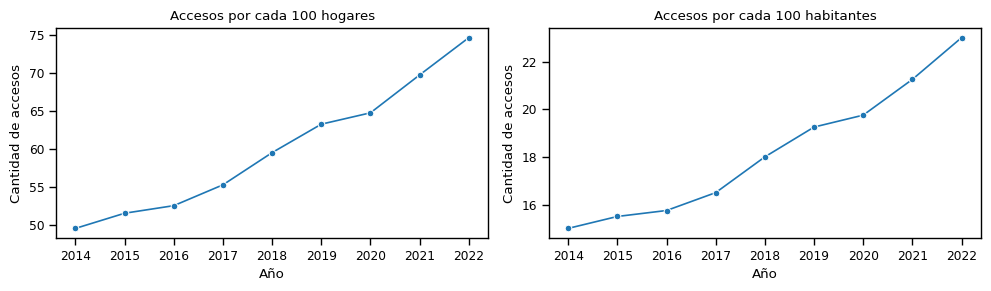

In [28]:
# Graficos que muestran la evolución de la Penetracion de internet fijo cada 100 hogares y cada 100 habitantes

sns.set_context('paper')

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(data=df_totales, x='Año', y='Accesos por cada 100 hogares', ci=None, marker='o', ax=axes[0])
axes[0].set_title('Accesos por cada 100 hogares')
axes[0].set_ylabel('Cantidad de accesos')

sns.lineplot(data=df_totales, x='Año', y='Accesos por cada 100 hab', ci=None, marker='o', ax=axes[1])
axes[1].set_title('Accesos por cada 100 habitantes')
axes[1].set_ylabel('Cantidad de accesos')

plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Se evidencia el crecimiento de la penetración del servicio de internet fijo en el país

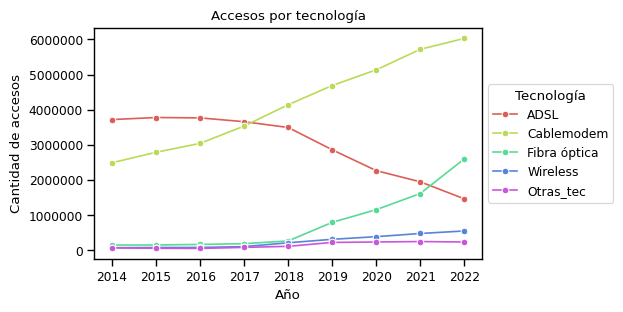

In [29]:
# Evolucón en el tiempo de la cantidad de accesos por tecnología

tipos_acceso = ['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otras_tec']

sns.set_context('paper')
plt.figure(figsize=(5, 3))
colores = sns.color_palette('hls', len(tipos_acceso))

for i, tipo in enumerate(tipos_acceso):
    sns.lineplot(data=df_totales, x='Año', y=tipo, color=colores[i], label=tipo, ci=None, marker='o')

plt.title('Accesos por tecnología')
plt.ylabel('Cantidad de accesos')
plt.legend(title='Tecnología', loc='center left', bbox_to_anchor=(1, 0.5))
plt.ticklabel_format(style='plain', axis='y')
plt.show()


En este gráfico se puede ver claramente las tecnologías que van quedando obsoletas (ADSL) y las que están en crecimiento (CableModem, Fibra óptica)

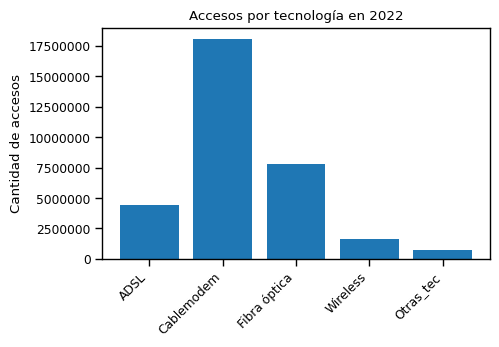

In [31]:
# Comparaciòn de accesos por tecnología en 2022

df_2022 = df_totales[df_totales['Año'] == 2022]
tecnologia = ['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otras_tec']
datos_2022 = df_2022[tecnologia].sum()

sns.set_context('paper')

plt.figure(figsize=(5, 3))
posiciones = range(len(tecnologia))
plt.bar(posiciones, datos_2022)
plt.xticks(posiciones, tecnologia, rotation=45, ha='right')
plt.title('Accesos por tecnología en 2022')
plt.ylabel('Cantidad de accesos')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

En este gráfico se puede ver que a la fecha del dataset (3er trimestre de 2022), la tecnología dominante en el país era el Cablemódem, seguida de la fibra óptica y ADSL, que según el gráfico anterior van creciendo su uso y decreciendo, respectivamente.

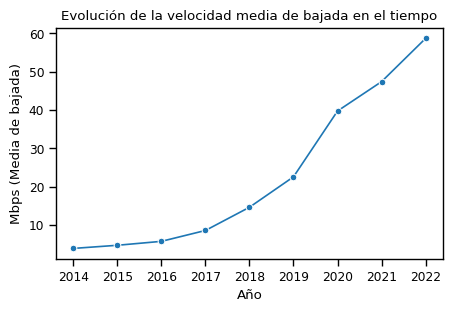

In [32]:
# Evolución de la velocidad media de bajada en el tiempo
sns.set_context('paper')
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_totales, x='Año', y='Mbps (Media de bajada)', marker='o', ci=None)
plt.title('Evolución de la velocidad media de bajada en el tiempo')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [33]:
# Tasa de crecimiento anual de la velocidad media de bajada

df_VMediaBajada = df_totales.groupby(['Año'])[['Mbps (Media de bajada)']].sum()
df_VMediaBajada['Porcentaje Crecimiento'] = ((df_VMediaBajada['Mbps (Media de bajada)'] - \
                                              df_VMediaBajada['Mbps (Media de bajada)'].shift(1)) / \
                                              df_VMediaBajada['Mbps (Media de bajada)'].shift(1)) * 100
print(df_VMediaBajada)

      Mbps (Media de bajada)  Porcentaje Crecimiento
Año                                                 
2014               15.399992                     NaN
2015               18.675020               21.266430
2016               22.783393               21.999296
2017               34.130709               49.805203
2018               58.380880               71.050886
2019               90.150000               54.416995
2020              158.870000               76.228508
2021              189.540000               19.305092
2022              176.010000               -7.138335


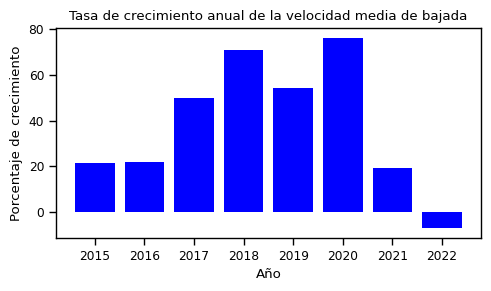

In [34]:
# Tasa de crecimiento anual de velocidad Media de bajada (Gráfico)

plt.figure(figsize=(5, 3))
plt.bar(df_VMediaBajada.index, df_VMediaBajada['Porcentaje Crecimiento'], color='blue')
plt.title('Tasa de crecimiento anual de la velocidad media de bajada')
plt.xlabel('Año')
plt.ylabel('Porcentaje de crecimiento')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

La tasa de crecimiento anual tuvo los valores más altos en el año 2018, posiblemente por el lanzamiento del Plan Nacional de Telecomunicaciones y Conectividad (https://www.argentina.gob.ar/noticias/macri-e-ibarra-presentaron-el-plan-nacional-de-telecomunicaciones-y-conectividad) y en el año 2020 quizas debido a la pandemia de covid-19 (https://www.telam.com.ar/notas/202106/557584-por-la-pandemia-el-volumen-del-trafico-de-internet-en-argentina-registro-un-nuevo-record.html5).
La caida de 2022 se debe a que no están los datos del año completo, llegan hasta el 3er trimestre.

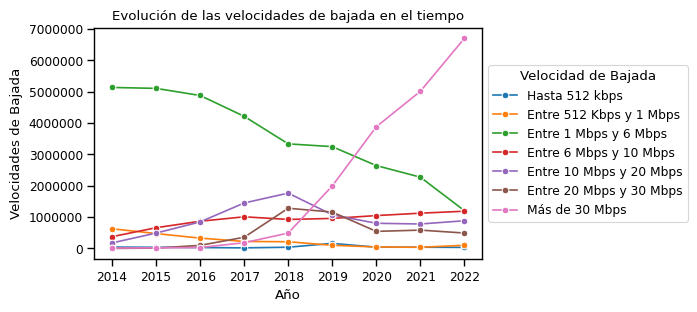

In [35]:
# Evolución de las velocidades de bajada en el tiempo
velocidades_bajada = ['Hasta 512 kbps', 'Entre 512 Kbps y 1 Mbps', 'Entre 1 Mbps y 6 Mbps',
                      'Entre 6 Mbps y 10 Mbps', 'Entre 10 Mbps y 20 Mbps', 'Entre 20 Mbps y 30 Mbps',
                      'Más de 30 Mbps']

sns.set_context("paper")
plt.figure(figsize=(5, 3))

for velocidad in velocidades_bajada:
    sns.lineplot(data=df_totales, x='Año', y=velocidad, marker='o', ci= None, label=velocidad)

plt.title('Evolución de las velocidades de bajada en el tiempo')
plt.ylabel('Velocidades de Bajada')
plt.legend(title='Velocidad de Bajada',loc='center left', bbox_to_anchor=(1, 0.5))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Aquí se puede ver que las velocidades de bajada entre 1 Mbps y 6 Mbps tienden a desaparecer y en sentido opuesto crecen considerablemente las conexiones mayores a 30 Mbps, esto probablemente esté asociado a la disminuciòn de conexiones Dial up y ADSL y al incremento de conexiones via Cablemodem y fibra óptica.

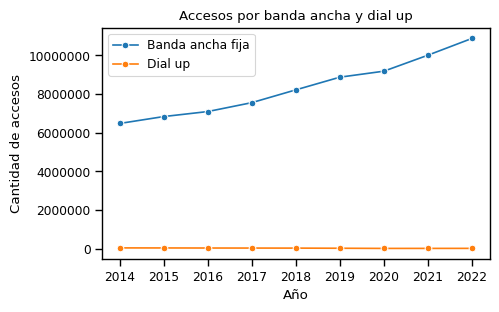

In [37]:
# Accesos por Banda Ancha y Dial Up

sns.set_context("paper")
plt.figure(figsize=(5, 3))

sns.lineplot(data=df_totales, x='Año', y='Banda ancha fija', ci=None, marker='o', label='Banda ancha fija')
sns.lineplot(data=df_totales, x='Año', y='Dial up', ci=None, marker='o', label='Dial up')

plt.title('Accesos por banda ancha y dial up')
plt.ylabel('Cantidad de accesos')
plt.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.show()


También en concordancia a los gráficos anteriores crecen los accesos con conexiones a banda ancha.

In [44]:
# Para evitar el sesgo producido por la inflación argentina se introduce una columna de cotización anual del dólar, se toma la cotización al 31/12 de cada año

df_totales['USDARS'] = 0
df_totales.loc[df_totales['Año'] == 2022, 'USDARS'] = 175.39
df_totales.loc[df_totales['Año'] == 2021, 'USDARS'] = 101.96
df_totales.loc[df_totales['Año'] == 2020, 'USDARS'] = 83.62
df_totales.loc[df_totales['Año'] == 2019, 'USDARS'] = 58.43
df_totales.loc[df_totales['Año'] == 2018, 'USDARS'] = 36.96
df_totales.loc[df_totales['Año'] == 2017, 'USDARS'] = 18.48
df_totales.loc[df_totales['Año'] == 2016, 'USDARS'] = 15.82
df_totales.loc[df_totales['Año'] == 2015, 'USDARS'] = 12.90
df_totales.loc[df_totales['Año'] == 2014, 'USDARS'] = 8.48

df_totales['Ingresos (dolares)'] = df_totales['Ingresos (miles de pesos)'] / df_totales['USDARS']

ruta_archivo = 'datasets/totales.csv'
df_totales.to_csv(ruta_archivo, index=False)

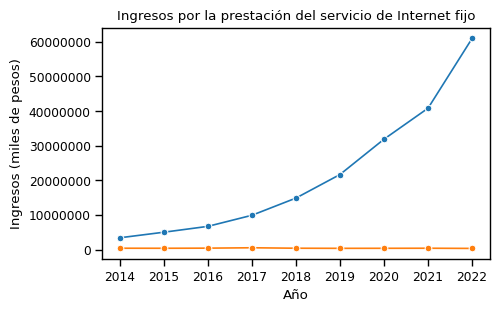

In [54]:
# Evolución de los ingresos por la prestación del servicio de Internet fijo

sns.set_context('paper')
plt.figure(figsize=(5, 3))
sns.lineplot(data=df_totales, x='Año', y='Ingresos (miles de pesos)', marker='o', ci=None)
sns.lineplot(data=df_totales, x='Año', y='Ingresos (dolares)', marker='o', ci=None)
plt.title('Ingresos por la prestación del servicio de Internet fijo')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [55]:
# Tasa de crecimiento anual de ingreso

df_ingresos = df_totales.groupby(['Año'])[['Ingresos (dolares)']].sum()
df_ingresos['Porcentaje Crecimiento'] = ((df_ingresos['Ingresos (dolares)'] - \
                                              df_ingresos['Ingresos (dolares)'].shift(1)) / \
                                              df_ingresos['Ingresos (dolares)'].shift(1)) * 100
print(df_ingresos)

      Ingresos (dolares)  Porcentaje Crecimiento
Año                                             
2014        1.613673e+06                     NaN
2015        1.558823e+06               -3.399104
2016        1.698325e+06                8.949226
2017        2.146752e+06               26.404036
2018        1.610920e+06              -24.960131
2019        1.485068e+06               -7.812408
2020        1.525781e+06                2.741508
2021        1.602431e+06                5.023633
2022        1.043284e+06              -34.893648


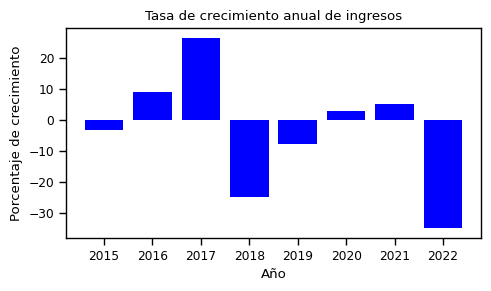

In [56]:
# Tasa de crecimiento anual de ingresos (Gráfico)

plt.figure(figsize=(5, 3))
plt.bar(df_ingresos.index, df_ingresos['Porcentaje Crecimiento'], color='blue')
plt.title('Tasa de crecimiento anual de ingresos')
plt.xlabel('Año')
plt.ylabel('Porcentaje de crecimiento')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

## Conectividad al servicio de Internet

In [57]:
df_conectividad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Provincia      4312 non-null   object 
 1   Partido        4312 non-null   object 
 2   Localidad      4312 non-null   object 
 3   Poblacion      4312 non-null   int64  
 4   ADSL           4312 non-null   object 
 5   CABLEMODEM     4312 non-null   object 
 6   DIALUP         4312 non-null   object 
 7   FIBRAOPTICA    4312 non-null   object 
 8   SATELITAL      4312 non-null   object 
 9   WIRELESS       4312 non-null   object 
 10  TELEFONIAFIJA  4312 non-null   object 
 11  3G             4312 non-null   object 
 12  4G             4312 non-null   object 
 13  link           4300 non-null   float64
 14  Latitud        4312 non-null   object 
 15  Longitud       4312 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory usage: 539.1+ KB


In [58]:
df_conectividad['Latitud'] = df_conectividad['Latitud'].str.replace(',', '.')
df_conectividad['Longitud'] = df_conectividad['Longitud'].str.replace(',', '.')

In [59]:
df_conectividad['Latitud'] = df_conectividad['Latitud'].apply(lambda x: re.sub('\.\.', '.', x))
df_conectividad['Longitud'] = df_conectividad['Longitud'].apply(lambda x: re.sub('\.\.', '.', x))

In [60]:
df_conectividad['Latitud'] = df_conectividad['Latitud'].astype(float)
df_conectividad['Longitud'] = df_conectividad['Longitud'].astype(float)

In [61]:
df_conectividad.sample(5)

Provincia         Partido                 Localidad  Poblacion ADSL  \
2496   CORDOBA       San Justo  Villa Concepción del Tío       1848   --   
747   SANTA FE      San Martín              María Susana       3197   SI   
1198  SANTA FE     Castellanos             Colonia Cello        118   --   
4177     CHACO  General Güemes          Fuerte Esperanza       1376   --   
1421  SAN LUIS       Chacabuco                  El Sauce          0   --   

     CABLEMODEM DIALUP FIBRAOPTICA SATELITAL WIRELESS TELEFONIAFIJA  3G  4G  \
2496         SI     --          --        --       SI            SI  SI  SI   
747          --     --          SI        --       SI            SI  SI  SI   
1198         --     --          --        --       SI            SI  --  SI   
4177         --     --          SI        SI       --            --  --  SI   
1421         --     --          --        --       --            --  --  --   

            link    Latitud   Longitud  
2496  14140420.0 -31.322469 -62.814475  
747   82126120.0 -32.265486 -61.901025  
1198  82021100.0 -31.433850 -61.841702  
4177  22063050.0 -25.156060 -61.842410  
1421  74028080.0 -32.522483 -65.235781

In [62]:
ruta_archivo = 'datasets/conectividad.csv'
df_conectividad.to_csv(ruta_archivo, index=False)

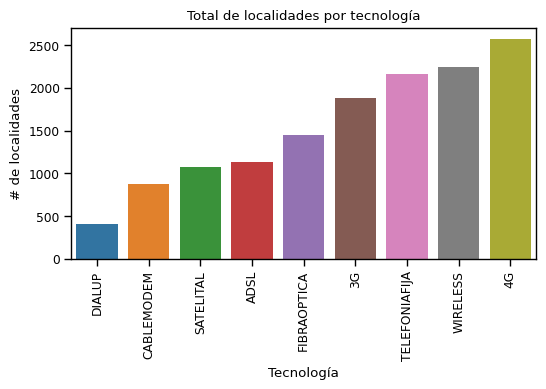

In [63]:
# Cantidad de localidades que poseen una tecnología

tecnologias = ['ADSL', 'CABLEMODEM', 'DIALUP', 'FIBRAOPTICA', 'SATELITAL', 'WIRELESS', 'TELEFONIAFIJA', '3G', '4G']
ocurrencias = [df_conectividad[tecnologia].value_counts()['SI'] for tecnologia in tecnologias]

sns.set_context("paper")
plt.figure(figsize=(6, 3))
sns.barplot(x=tecnologias, y=ocurrencias, order=sorted(tecnologias, key=lambda x: ocurrencias[tecnologias.index(x)]))
plt.xlabel('Tecnología')
plt.ylabel('# de localidades')
plt.title('Total de localidades por tecnología')
plt.xticks(rotation=90)
plt.show()

Este gráfico muestra la cantidad de localidades dentro del país que cuentan con diferentes tecnologías de conexión a internet. Se ve que la mayorìa de las localidades cuentan con tecnologías 4G o 3G debido a la penetraciòn del servicio de telefonía móvil que, como se muestra más abajo, también con datos obtenidos del Enacom, entre 2013 y 2022 hay un promedio de casi 137 telefonos móviles cada 100 habitantes.

In [65]:
df_telefonia_movil = pd.read_csv('datasets\Telefonia_movil.csv')

In [66]:
df_telefonia_movil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Año                       39 non-null     int64 
 1   Trimestre                 39 non-null     int64 
 2   Accesos por cada 100 hab  39 non-null     int64 
 3   Periodo                   39 non-null     object
dtypes: int64(3), object(1)
memory usage: 1.3+ KB


In [67]:
df_telefonia_movil.sample(5)

Año  Trimestre  Accesos por cada 100 hab        Periodo
27  2019          4                       125   Oct-Dic 2019
5   2014          2                       143   Abr-Jun 2014
10  2015          3                       141  Jul-Sept 2015
38  2022          3                       129  Jul-Sept 2022
8   2015          1                       140   Ene-Mar 2015

In [68]:
media_accesos_por_hab = df_telefonia_movil['Accesos por cada 100 hab'].mean()
print("La cantidad media de accesos por habitante es:", media_accesos_por_hab)

La cantidad media de accesos por habitante es: 136.82051282051282


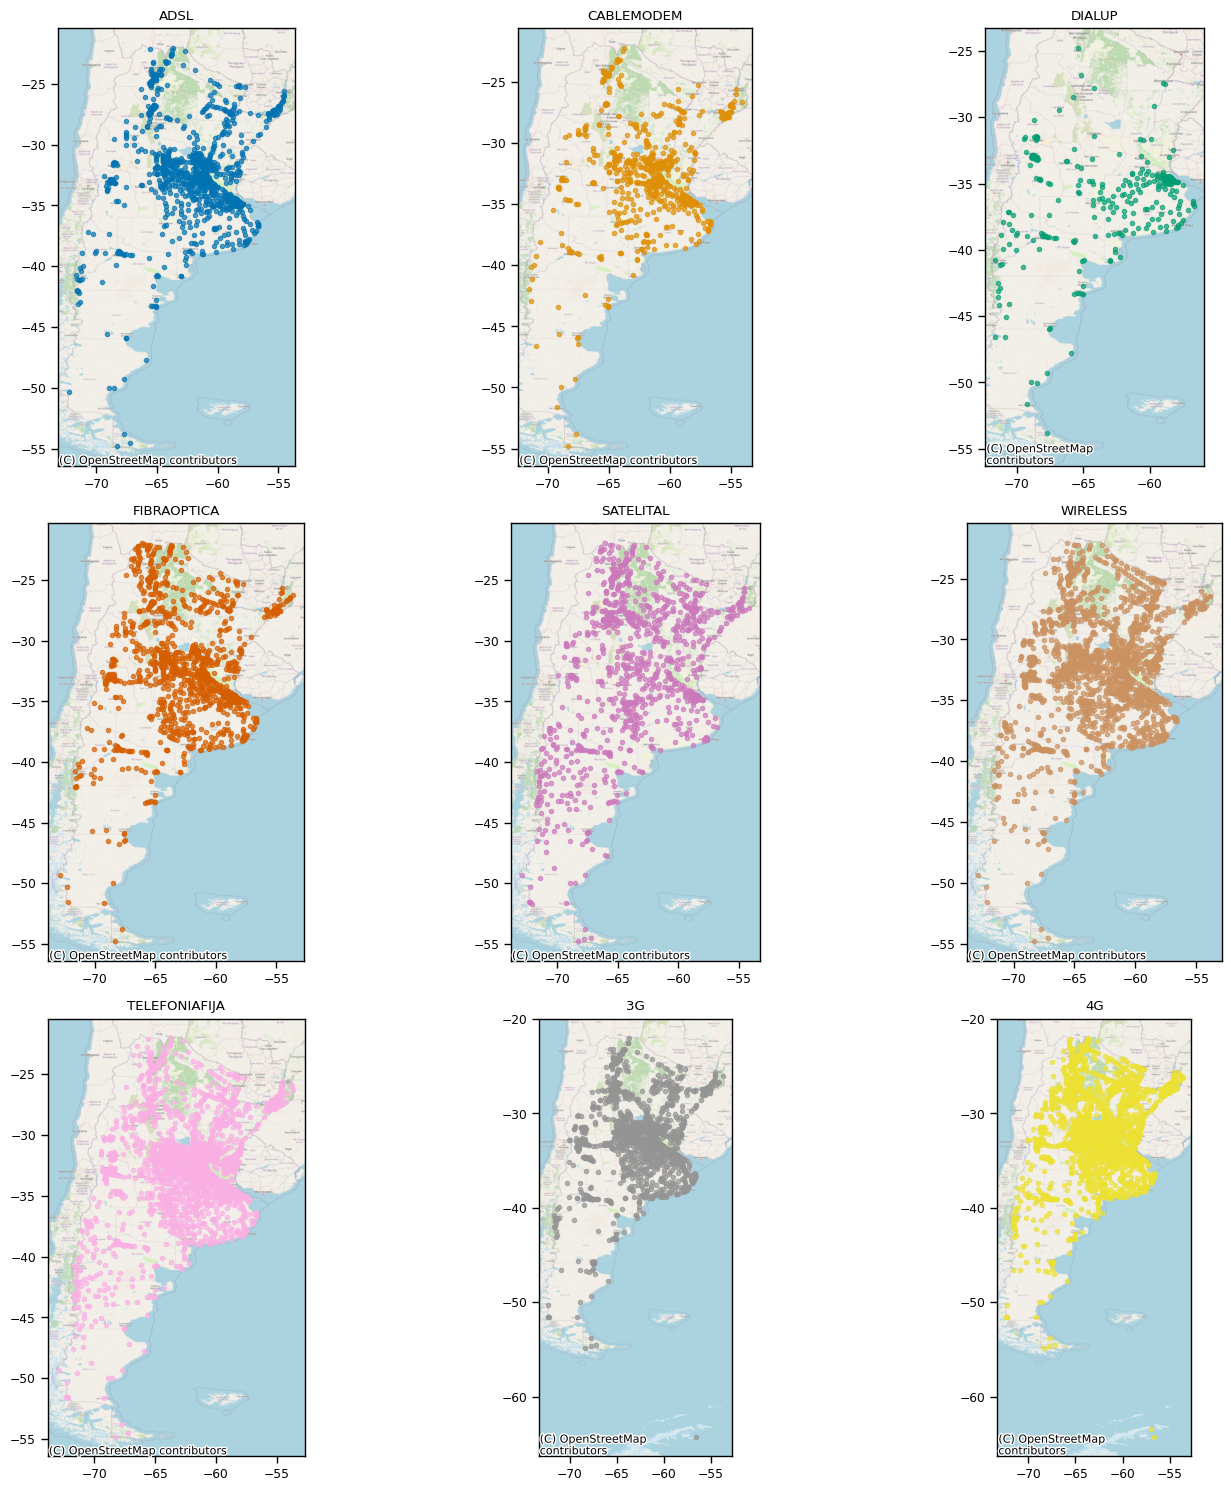

In [69]:
tecnologias = ['ADSL', 'CABLEMODEM', 'DIALUP', 'FIBRAOPTICA', 'SATELITAL', 'WIRELESS', 'TELEFONIAFIJA', '3G', '4G']

colores = sns.color_palette('colorblind',len(tecnologias))

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for tecnologia, color, ax in zip(tecnologias, colores, axs.flatten()):
    df_tecnologia = df_conectividad[df_conectividad[tecnologia] == 'SI']
    latitudes = df_tecnologia['Latitud'].astype(float)
    longitudes = df_tecnologia['Longitud'].astype(float)
    ax.scatter(longitudes, latitudes, color=color, alpha=0.7, s=10)
    ax.set_title(tecnologia)
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()

En estos mapas se puede ver gráficamente las tecnologías presentes en las localidades del país. La ayor concentración de localidades conectas y tecnologías está en la región centro del país, presentando una menor densidad de conexiones en la patagonia.
También ayudan a comprender el grafico de barras anterior mostrando, por ejemplo, la baja densidad de conexiones tipo Dial up.

In [128]:
# Se calcula el porcentaje de cada tecnología por provincia
resultados = {}
tecnologias = ['ADSL', 'CABLEMODEM', 'DIALUP', 'FIBRAOPTICA', 'SATELITAL', 'WIRELESS', 'TELEFONIAFIJA', '3G', '4G']

for tecnologia in tecnologias:
    resultados[tecnologia] = df_conectividad.groupby('Provincia')[tecnologia].apply(
        lambda x: (x == 'SI').sum() / len(x) * 100)

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.reset_index()
df_resultados = df_resultados.rename(columns={'index': 'Provincia'})
df_resultados['Provincia'] = df_resultados['Provincia'].str.title()

In [124]:
# Para une mejor comprension y analisis de los datos se divide el pais segun las regiones del INDEC

# Regiones INDEC
NOA=['Catamarca', 'Jujuy', 'La Rioja', 'Salta', 'Santiago Del Estero', 'Tucuman', 'Tucumán']
NEA=['Chaco', 'Corrientes', 'Formosa', 'Misiones']
Cuyo=['Mendoza', 'San Juan', 'San Luis']
Pampeana=['Buenos Aires', 'Caba', 'Capital Federal', 'Cordoba', 'Córdoba', 'Entre Rios', 'Entre Ríos', 'La Pampa', 'Santa Fe']
Patagonia=['Neuquen', 'Neuquén', 'Rio Negro', 'Río Negro', 'Santa Cruz', 'Tierra Del Fuego']

regiones = {
    'NOA': NOA,
    'NEA': NEA,
    'Cuyo': Cuyo,
    'Pampeana': Pampeana,
    'Patagonia': Patagonia
}

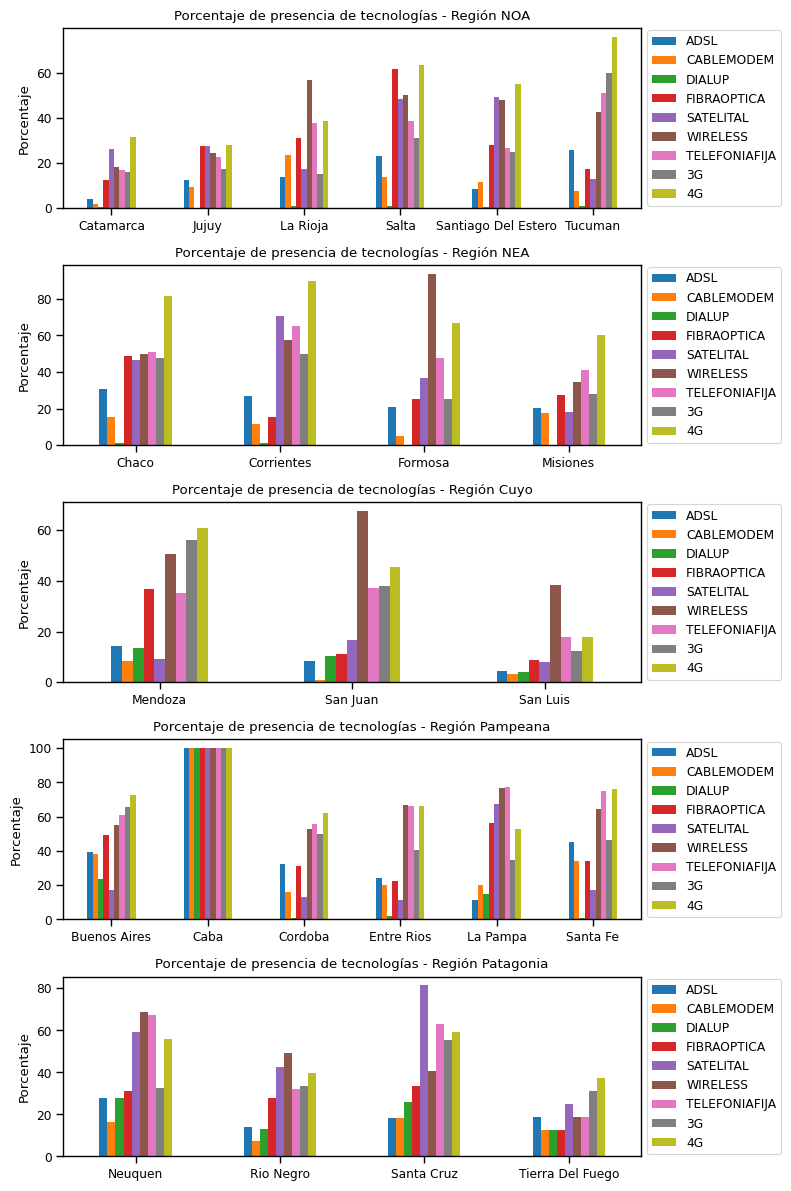

In [72]:
# Porcentaje de presencia de tecnologías en locailidades, por provincias y regiones
fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

sns.set_context("paper")

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_resultados[df_resultados['Provincia'].isin(provincias)]
    ax = axs[i]
    df_region[tecnologias].plot(kind='bar', ax=ax, legend=False)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'Porcentaje de presencia de tecnologías - Región {region}')
    ax.set_ylabel('Porcentaje')
    ax.set_xticklabels(df_region.Provincia, rotation=0)

plt.tight_layout()
plt.show()

Estos gráficos por provincia y región muestran la misma tendencia del gráfico general donde quedaba evidente la preominancia de la tecnología 4G, pero permiten ver que en las regiones de Cuyo y Patagonia hay otro tipo de tecnologías dominantes.

In [129]:
provincias_corregidas= {
    'Tierra Del Fuego': 'Tierra del Fuego',
    'Caba': 'Capital Federal',
    'Santiago Del Estero': 'Santiago del Estero'
}
df_mapa=df_resultados
df_mapa['Provincia'] = df_mapa['Provincia'].replace(provincias_corregidas)

A continuación se presenta un mapa coroplético de los accesos 4G en todo el paìs, dejando evidente que es una de las tecnologías más usadas.

In [136]:
# Mapa coroplético para accesos por 4G
m = folium.Map(location=[-38.40, -63.60],min_zoom=4, max_zoom=4, width='40%', height='80%', zoom_control=False, )

folium.Choropleth(
    geo_data='ProvinciasArgentina.geojson',
    data=df_mapa,
    columns=['Provincia', '4G'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd',
    bins=20,
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='Acceso por 4G (%)',
).add_to(m)
m

Estos dos mapas coropléticos se realizan para evidenciar la presencia de conexiones diferentes a la 4G, por ejemplo en Formosa, La Pampa, San Juan y Neuquén hay un predominio de red Wireless o Acceso Inalámbrico y en la región patagónica se ve un predominio de conexiones satelitales.
Se puede acceder a las definiciones de estos y los demás tipos de conexión en (https://www.enacom.gob.ar/tipos-de-conexion_p112)

In [134]:
# Mapa coroplético para accesos por wireless
m = folium.Map(location=[-38.40, -63.60],min_zoom=4, max_zoom=4, width='40%', height='80%', zoom_control=False, )

folium.Choropleth(
    geo_data='ProvinciasArgentina.geojson',
    data=df_mapa,
    columns=['Provincia', 'WIRELESS'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd',
    bins=20,
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='Acceso por Wireless (%)',
).add_to(m)
m

In [133]:
# Mapa coroplético para accesos satelitales
m = folium.Map(location=[-38.40, -63.60],min_zoom=4, max_zoom=4, width='40%', height='80%', zoom_control=False, )

folium.Choropleth(
    geo_data='ProvinciasArgentina.geojson',
    data=df_mapa,
    columns=['Provincia', 'SATELITAL'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd',
    bins=20,
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='Acceso Satelital (%)',
).add_to(m)
m

## Accesos a Banda Ancha y Banda Angosta

In [92]:
df_banda_ancha_angosta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               840 non-null    int64  
 1   Trimestre         840 non-null    int64  
 2   Provincia         840 non-null    object 
 3   Banda ancha fija  840 non-null    int64  
 4   Dial up           838 non-null    float64
 5   Total             840 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 39.5+ KB


In [93]:
df_banda_ancha_angosta = df_banda_ancha_angosta.dropna()

In [94]:
df_banda_ancha_angosta['Dial up'] = df_banda_ancha_angosta['Dial up'].astype(np.int64)

In [95]:
df_banda_ancha_angosta.sample(5)

Año  Trimestre            Provincia  Banda ancha fija  Dial up    Total
285  2019          4  Santiago Del Estero            103587        1   103588
720  2015          1         Buenos Aires           2847076    14766  2861842
225  2020          2                Jujuy             94316        0    94316
490  2017          3             La Pampa             79280      410    79690
408  2018          2         Buenos Aires           3490134    10565  3500699

In [105]:
ruta_archivo = 'datasets/banda_ancha_angosta.csv'
df_banda_ancha_angosta.to_csv(ruta_archivo, index=False)

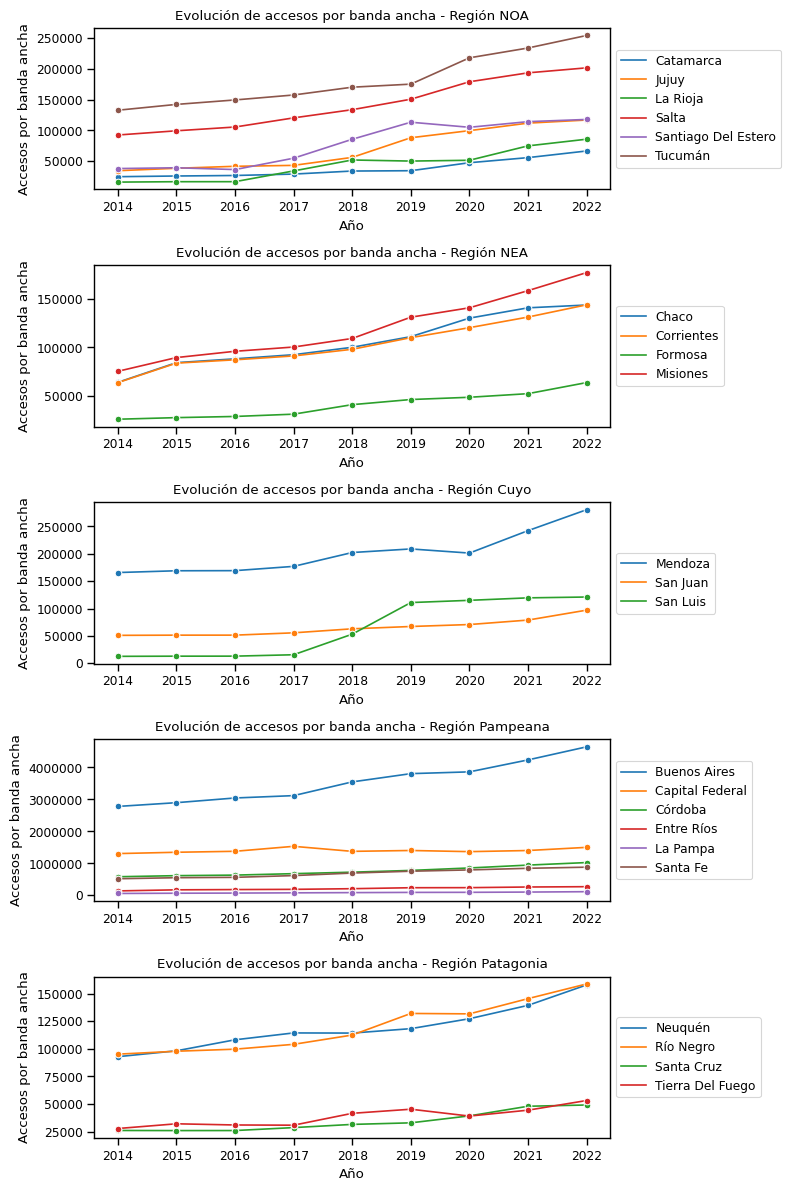

In [96]:
# Evolución en el tiempo de accesos por Banda ancha

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_banda_ancha_angosta[df_banda_ancha_angosta['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Banda ancha fija', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Evolución de accesos por banda ancha - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Accesos por banda ancha')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.show()


Estos gráficos confirman lo que se vio anteriormente acerca del crecimiento de accesos de banda ancha, esto es una constante en todas las provincias.

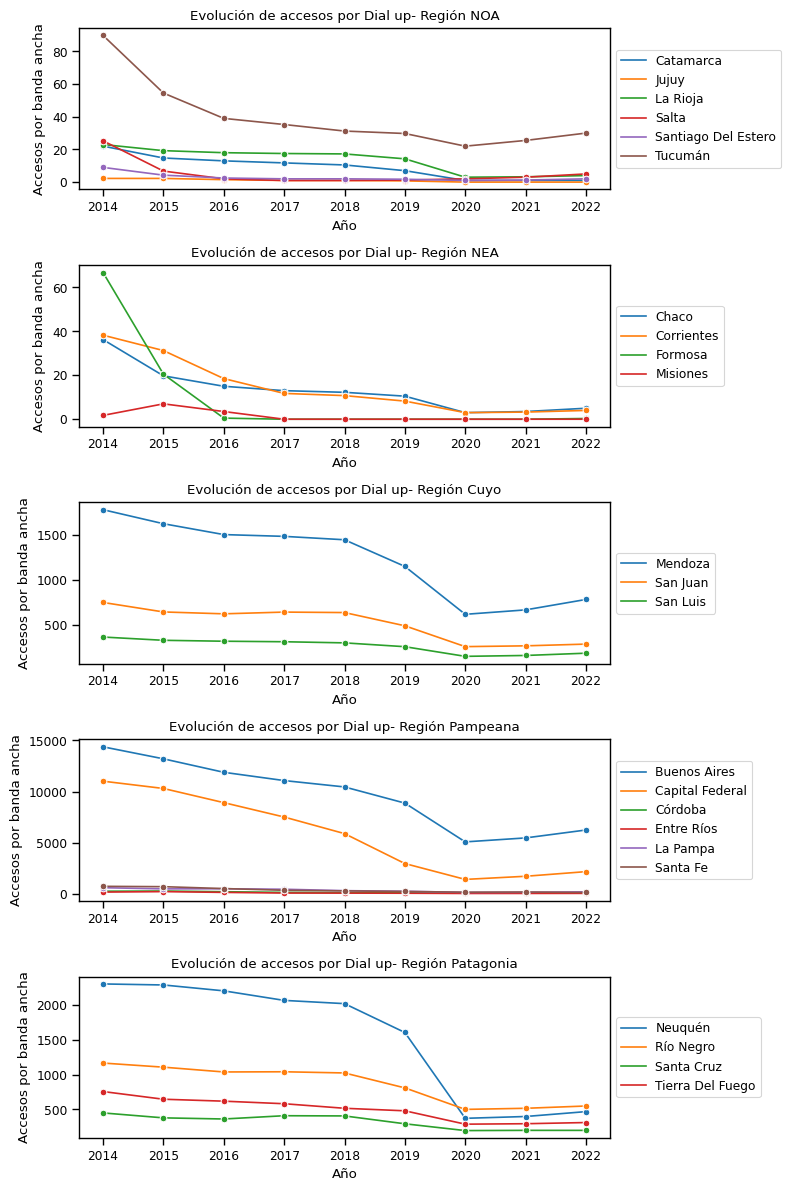

In [106]:
# Evolución en el tiempo de accesos por Dial up

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_banda_ancha_angosta[df_banda_ancha_angosta['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Dial up', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Evolución de accesos por Dial up- Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Accesos por banda ancha')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

En estos gráficos también se confirma lo visto en el análisis de otras tablas, que cada vez es menor el uso de conexion Dial up.

## Penetracion de Internet Fijo

In [107]:
df_penetracion = pd.merge(df_penetracion_poblacion, df_penetracion_hogares, on=['Año', 'Trimestre', 'Provincia'])

In [108]:
df_penetracion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Año                           840 non-null    int64  
 1   Trimestre                     840 non-null    int64  
 2   Provincia                     840 non-null    object 
 3   Accesos por cada 100 hab      840 non-null    float64
 4   Accesos por cada 100 hogares  840 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 32.9+ KB


In [109]:
df_penetracion.sample(5)

Año  Trimestre     Provincia  Accesos por cada 100 hab  \
427  2018          2    Santa Cruz                  9.919588   
603  2016          2         Chaco                  7.642897   
251  2020          1      La Rioja                 12.337424   
528  2017          1  Buenos Aires                 18.804855   
445  2018          1      Misiones                  8.432278   

     Accesos por cada 100 hogares  
427                     33.332365  
603                     28.593551  
251                     46.346631  
528                     58.574002  
445                     30.956736

In [111]:
ruta_archivo = 'datasets/penetracion.csv'
df_penetracion.to_csv(ruta_archivo, index=False)

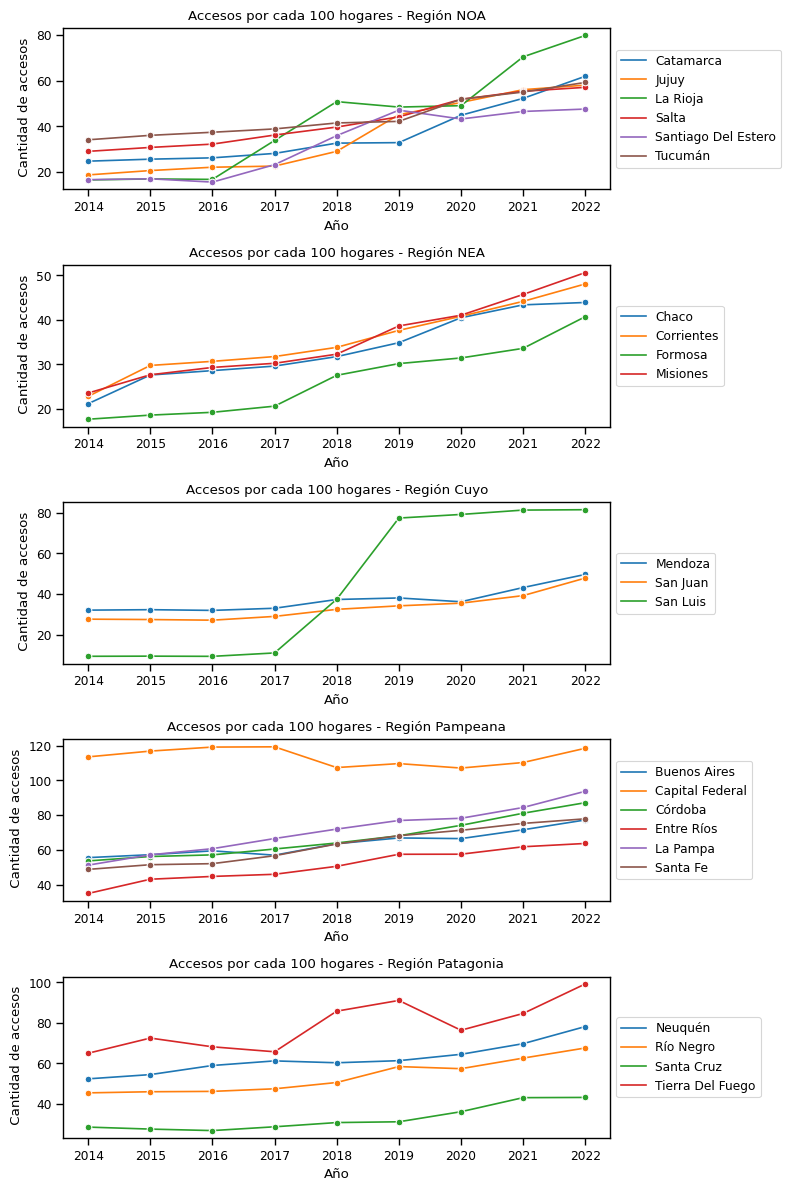

In [112]:
# Penetración de internet fijo cada 100 hogares

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_penetracion[df_penetracion['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Accesos por cada 100 hogares', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Accesos por cada 100 hogares - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel(' Cantidad de accesos')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.show()


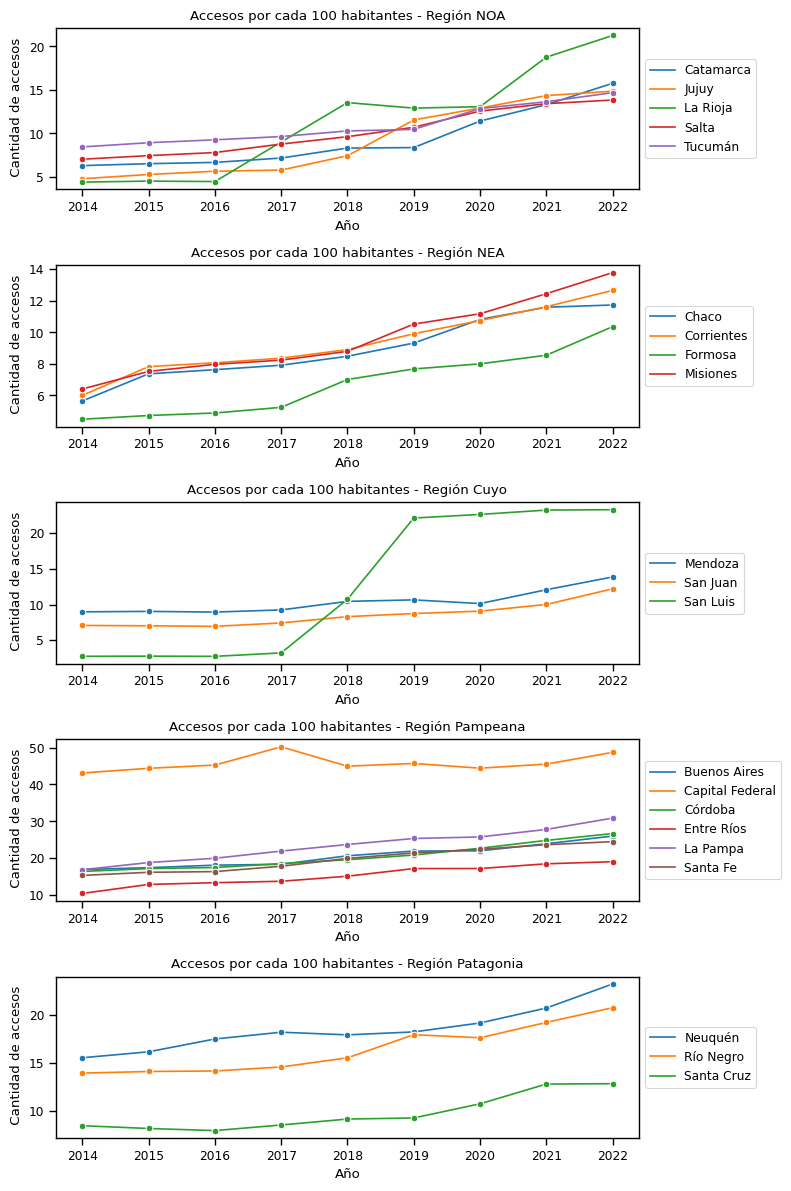

In [138]:
# Penetración de internet fijo cada 100 habitantes

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_penetracion[df_penetracion['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Accesos por cada 100 hab', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Accesos por cada 100 habitantes - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel(' Cantidad de accesos')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [142]:
provincias_corregidas= {
    'Tucumán': 'Tucuman',
    'Tierra Del Fuego': 'Tierra del Fuego',
    'Caba': 'Capital Federal',
    'Córdoba': 'Cordoba',
    'Entre Ríos': 'Entre Rios',
    'Neuquén': 'Neuquen',
    'Río Negro': 'Rio Negro',
    'Santiago Del Estero': 'Santiago del Estero'
}
df_mapa=df_penetracion
df_mapa['Provincia'] = df_mapa['Provincia'].replace(provincias_corregidas)

In [143]:
df_mapa = df_mapa[df_mapa['Año'] == 2022].groupby('Provincia').sum().reset_index()

In [144]:
# Mapa croropletico para accesos cada 100 hogares
m = folium.Map(location=[-38.40, -63.60],min_zoom=4, max_zoom=4, width='40%', height='80%', zoom_control=False, )

folium.Choropleth(
    geo_data='ProvinciasArgentina.geojson',
    data=df_mapa,
    columns=['Provincia', 'Accesos por cada 100 hogares'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd',
    bins=20,
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='Acceso por Wireless (%)',
).add_to(m)
m

In [145]:
# Mapa croropletico para accesos cada 100 habitantes
m = folium.Map(location=[-38.40, -63.60],min_zoom=4, max_zoom=4, width='40%', height='80%', zoom_control=False, )

folium.Choropleth(
    geo_data='ProvinciasArgentina.geojson',
    data=df_mapa,
    columns=['Provincia', 'Accesos por cada 100 hab'],
    key_on='feature.properties.nombre',
    fill_color='YlOrRd',
    bins=20,
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='Acceso por Wireless (%)',
).add_to(m)
m

Estos dos mapas muestran que la mayor penetraciòn del servicio de internet se da en las provincias del centro del país.

## Velocidad media de bajada

In [146]:
df_velocidad_bajada_provincia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año                     840 non-null    int64  
 1   Trimestre               840 non-null    int64  
 2   Provincia               840 non-null    object 
 3   Mbps (Media de bajada)  840 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 26.4+ KB


In [147]:
df_velocidad_bajada_provincia.describe()

Año   Trimestre  Mbps (Media de bajada)
count   840.000000  840.000000              840.000000
mean   2017.885714    2.457143               13.857271
std       2.528745    1.105009               14.666449
min    2014.000000    1.000000                2.573729
25%    2016.000000    1.000000                4.248956
50%    2018.000000    2.000000                7.098248
75%    2020.000000    3.000000               18.320004
max    2022.000000    4.000000              101.050000

In [148]:
df_velocidad_bajada_provincia.sample(5)

Año  Trimestre   Provincia  Mbps (Media de bajada)
340  2019          1      Chubut                5.891731
167  2021          1     Tucumán               37.979620
163  2021          1  Santa Cruz                7.501532
740  2015          1    Santa Fe                4.063283
497  2017          3    San Juan                3.449784

In [149]:
ruta_archivo = 'datasets/velocidad_bajada_provincia.csv'
df_velocidad_bajada_provincia.to_csv(ruta_archivo, index=False)

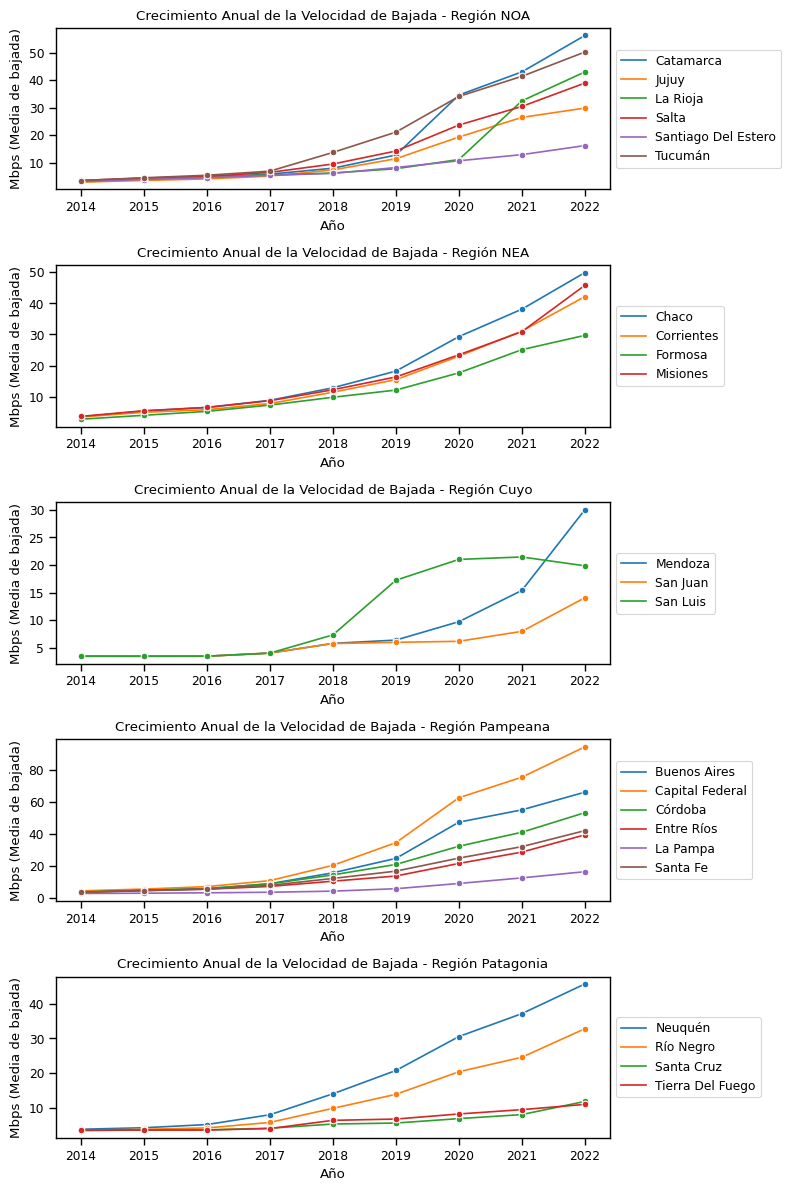

In [150]:
# Crecimiento anual de la velocodad de bajada

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_velocidad_bajada_provincia[df_velocidad_bajada_provincia['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Mbps (Media de bajada)', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Crecimiento Anual de la Velocidad de Bajada - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Mbps (Media de bajada)')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Como ya se pudo apreciar en gráficos anteriores, la velocidad de bajada tiene un marcado crecimiento, consecuencia de las mejoras en tecnología.

## Accesos a Internet fijo por tecnología

In [151]:
df_accesos_tecnologia_provincia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Año           841 non-null    object 
 1   Trimestre     841 non-null    object 
 2   Provincia     840 non-null    object 
 3   ADSL          840 non-null    float64
 4   Cablemodem    840 non-null    float64
 5   Fibra óptica  840 non-null    float64
 6   Wireless      840 non-null    float64
 7   Otros         840 non-null    float64
 8   Total         840 non-null    float64
dtypes: float64(6), object(3)
memory usage: 59.3+ KB


In [152]:
df_accesos_tecnologia_provincia.tail()

Año                                          Trimestre  \
837  2014                                                  1   
838  2014                                                  1   
839  2014                                                  1   
840   NaN                                                NaN   
841     *  Los datos provinciales no coinciden a nivel na...   

               Provincia      ADSL  Cablemodem  Fibra óptica  Wireless  \
837  Santiago Del Estero   32567.0      3598.0          19.0     915.0   
838     Tierra Del Fuego   21618.0      2837.0         648.0       1.0   
839              Tucumán  129717.0        83.0         121.0      13.0   
840                  NaN       NaN         NaN           NaN       NaN   
841                  NaN       NaN         NaN           NaN       NaN   

      Otros     Total  
837    34.0   37133.0  
838  2934.0   28038.0  
839    98.0  130032.0  
840     NaN       NaN  
841     NaN       NaN

In [153]:
df_accesos_tecnologia_provincia = df_accesos_tecnologia_provincia.iloc[:-2]

In [155]:
def limpiar_caracter(valor):
    if isinstance(valor, str):
        valor_limpio = re.sub(r'\*', '', valor)
        return valor_limpio
    return valor

# Aplicar la función de limpieza a las columnas 'Año' y 'Trimestre'
df_accesos_tecnologia_provincia['Año'] = df_accesos_tecnologia_provincia['Año'].apply(limpiar_caracter)
df_accesos_tecnologia_provincia['Trimestre'] = df_accesos_tecnologia_provincia['Trimestre'].apply(limpiar_caracter)

In [156]:
df_accesos_tecnologia_provincia['Año'] = df_accesos_tecnologia_provincia['Año'].astype(np.int64)
df_accesos_tecnologia_provincia['Trimestre'] = df_accesos_tecnologia_provincia['Trimestre'].astype(np.int64)

In [157]:
ruta_archivo = 'datasets/accesos_tecnologia_provincia.csv'
df_accesos_tecnologia_provincia.to_csv(ruta_archivo, index=False)

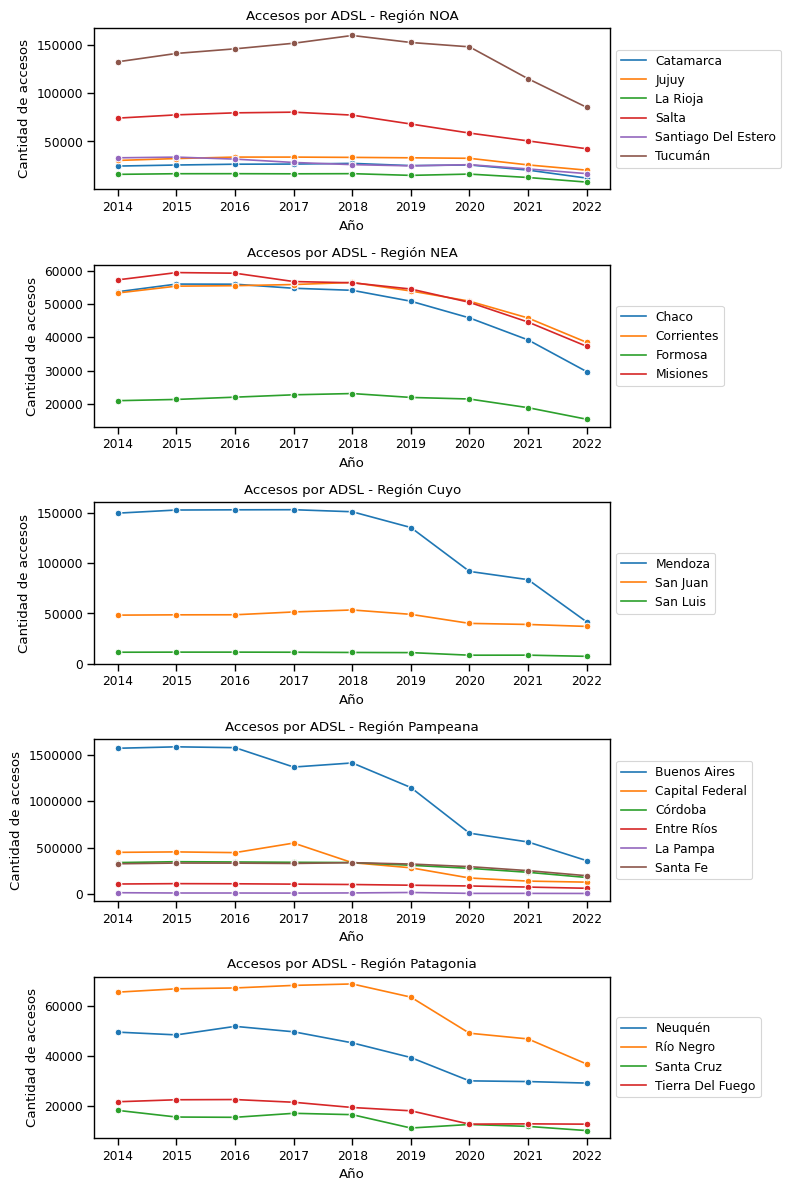

In [158]:
# Evolución en el tiempo de cantidad de accesos por ADSL

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_accesos_tecnologia_provincia[df_accesos_tecnologia_provincia['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='ADSL', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Accesos por ADSL - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Cantidad de accesos')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

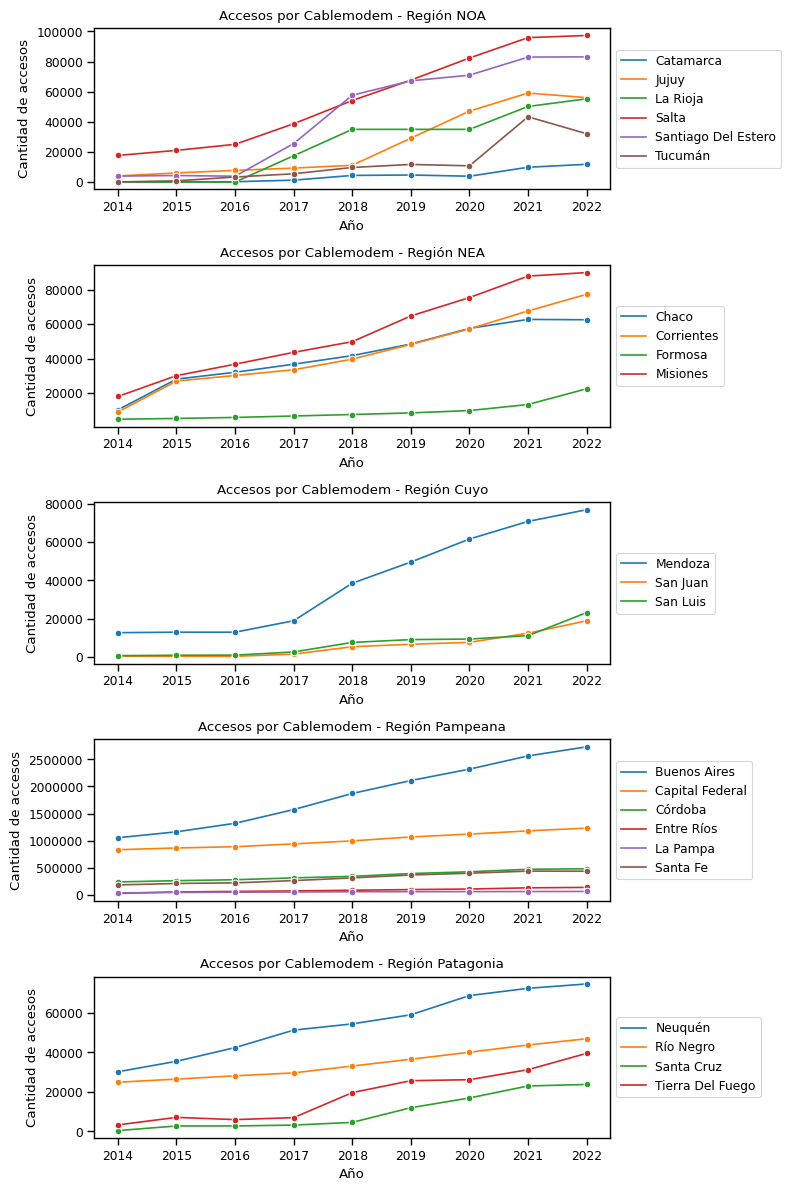

In [159]:
# Evolución en el tiempo de cantidad de accesos por Cablemodem

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_accesos_tecnologia_provincia[df_accesos_tecnologia_provincia['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Cablemodem', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Accesos por Cablemodem - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Cantidad de accesos')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

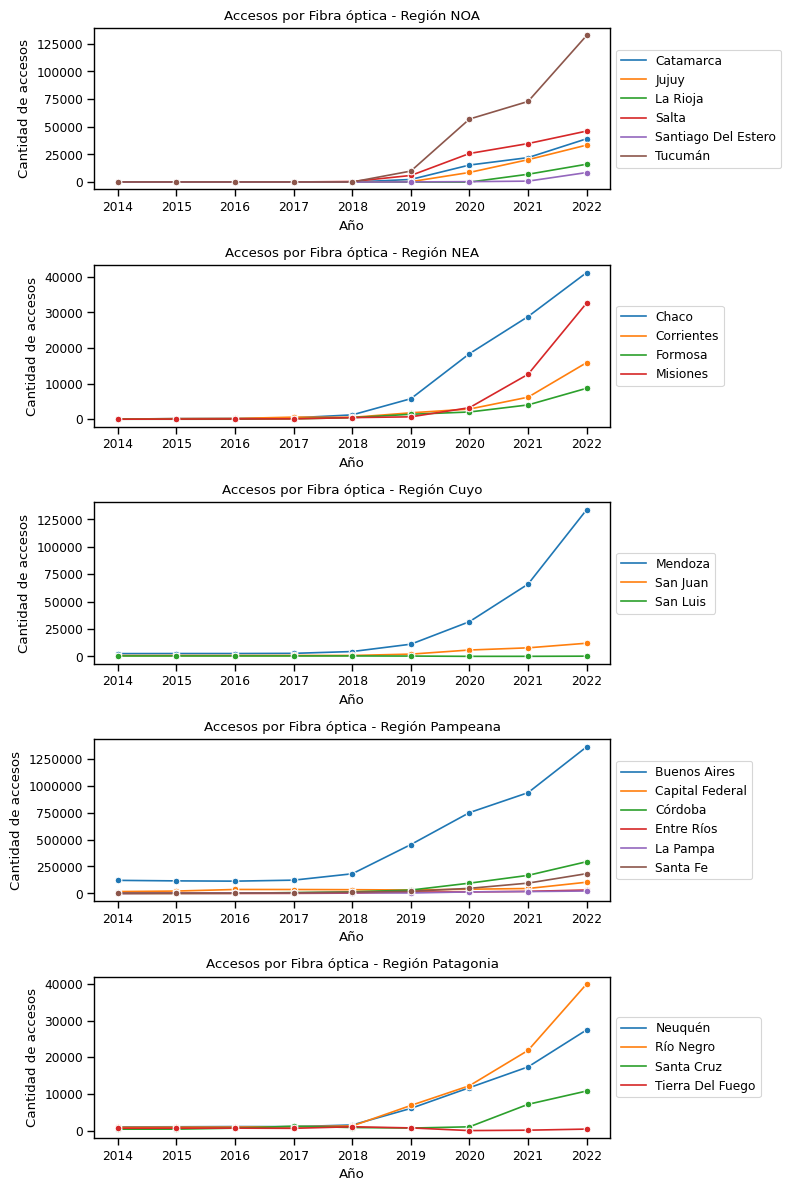

In [160]:
# Evolución en el tiempo de cantidad de accesos por Fibra óptica

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_accesos_tecnologia_provincia[df_accesos_tecnologia_provincia['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Fibra óptica', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Accesos por Fibra óptica - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Cantidad de accesos')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

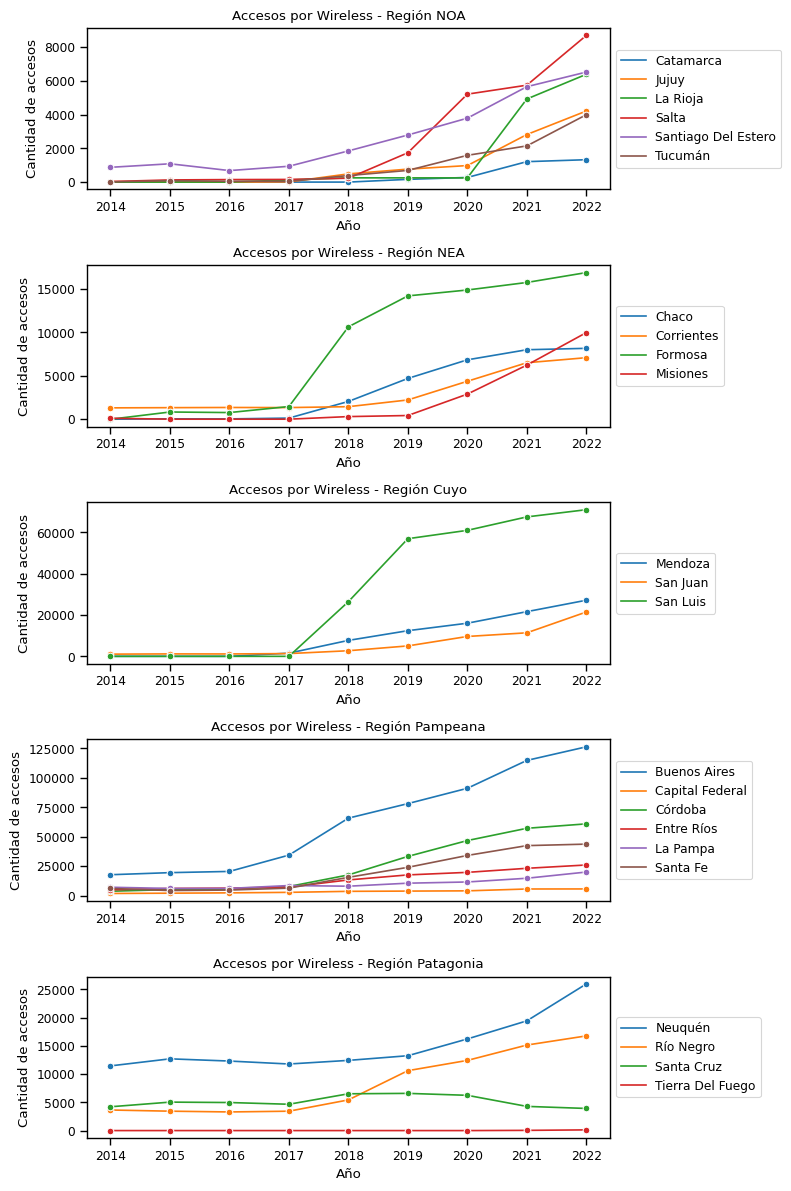

In [162]:
# Evolución en el tiempo de cantidad de accesos por Wireless

fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_accesos_tecnologia_provincia[df_accesos_tecnologia_provincia['Provincia'].isin(provincias)]
    ax = axs[i]

    sns.lineplot(data=df_region, x='Año', y='Wireless', hue='Provincia', marker='o', ci= None, ax=ax)

    ax.set_title(f'Accesos por Wireless - Región {region}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Cantidad de accesos')
    ax.set_xticks(df_region['Año'].unique())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Esta serie de gráficos des evolución de tecnologías por provincia no hace más que confirmar lo visto a nivel nacional, la conexión ADSL está quedando obsoleta, mientras que as tecnologías en crecimiento son el Cablemodem, la fibra óptica y, en algunas provincias el wireless.

## Accesos tecnologia por localidad

In [163]:
df_accesos_tecnologia_localidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Provincia      3142 non-null   object
 1   Partido        3142 non-null   object
 2   Localidad      3142 non-null   object
 3   Link Indec     3142 non-null   object
 4   ADSL           3142 non-null   int64 
 5   CABLEMODEM     3142 non-null   int64 
 6   DIAL UP        3142 non-null   int64 
 7   FIBRA OPTICA   3142 non-null   int64 
 8   OTROS          3142 non-null   int64 
 9   SATELITAL      3142 non-null   int64 
 10  WIMAX          3142 non-null   int64 
 11  WIRELESS       3142 non-null   int64 
 12  Total general  3142 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 319.2+ KB


In [164]:
df_accesos_tecnologia_localidad.describe()

ADSL    CABLEMODEM      DIAL UP   FIBRA OPTICA         OTROS  \
count    3142.000000  3.142000e+03  3142.000000    3142.000000   3142.000000   
mean      444.072884  1.919787e+03     3.958307     913.921388     69.207193   
std      3247.312984  2.368834e+04    44.704276    6213.194911    881.659067   
min         0.000000  0.000000e+00     0.000000       0.000000      0.000000   
25%         0.000000  0.000000e+00     0.000000       0.000000      0.000000   
50%         0.000000  0.000000e+00     0.000000       0.000000      0.000000   
75%       113.750000  9.000000e+00     0.000000      57.750000      0.000000   
max    140791.000000  1.240125e+06  2145.000000  208950.000000  29585.000000   

         SATELITAL        WIMAX      WIRELESS  Total general  
count  3142.000000  3142.000000   3142.000000   3.142000e+03  
mean      1.030236     0.670592    177.310630   3.529958e+03  
std      17.535193    14.883203    685.352342   3.155495e+04  
min       0.000000     0.000000      0.000000   0.000000e+00  
25%       0.000000     0.000000      0.000000   2.225000e+01  
50%       0.000000     0.000000     21.000000   1.510000e+02  
75%       1.000000     0.000000    113.000000   9.822500e+02  
max     975.000000   444.000000  18447.000000   1.547679e+06

In [173]:
df_accesos_tecnologia_localidad.sample(5)

Provincia         Partido                       Localidad  \
2152            RIO NEGRO      9 de Julio            Ministro Ramos Mexía   
3013  SANTIAGO DEL ESTERO          Loreto  Villa San Martín (Est. Loreto)   
1286              CORDOBA  Tercero Arriba                  Punta del Agua   
3027  SANTIAGO DEL ESTERO     Ojo de Agua                           OTROS   
706          BUENOS AIRES       Villarino   Juan Cousté  (Est. Algarrobo)   

     Link Indec  ADSL  CABLEMODEM  DIAL UP  FIBRA OPTICA  OTROS  SATELITAL  \
2152   62049030     0           0        0             6      1          1   
3013   86105010     0           0        0             0      1          1   
1286   14161140     0           0        0             0      0          0   
3027  Sin Datos     0           0        0             0      4          4   
706     6875040     0           0        2             0      2          0   

      WIMAX  WIRELESS  Total general  
2152      0       146            153  
3013      0       341            342  
1286      0         1              1  
3027      0         0              4  
706       0        82             84

In [167]:
ruta_archivo = 'datasets/accesos_tecnologia_localidad.csv'
df_accesos_tecnologia_localidad.to_csv(ruta_archivo, index=False)

In [166]:
df_accesos_tecnologia_localidad.columns

Index(['Provincia', 'Partido', 'Localidad', 'Link Indec', 'ADSL', 'CABLEMODEM',
       'DIAL UP', 'FIBRA OPTICA', 'OTROS', 'SATELITAL', 'WIMAX', 'WIRELESS',
       'Total general'],
      dtype='object')

In [168]:
tecnologias_seleccionadas = ['ADSL', 'CABLEMODEM', 'FIBRA OPTICA', 'WIRELESS']
tecnologias_no_seleccionadas = ['DIAL UP', 'OTROS', 'SATELITAL', 'WIMAX']
df_accesos_tecnologia_localidad['OTROS'] = df_accesos_tecnologia_localidad[tecnologias_no_seleccionadas].sum(axis=1) + df_accesos_tecnologia_localidad['OTROS']
df_provincias = df_accesos_tecnologia_localidad[['Provincia'] + tecnologias_seleccionadas + ['OTROS']]
df_provincias = df_provincias.groupby('Provincia').sum().reset_index()

In [169]:
df_provincias['Provincia']=df_provincias['Provincia'].str.title()

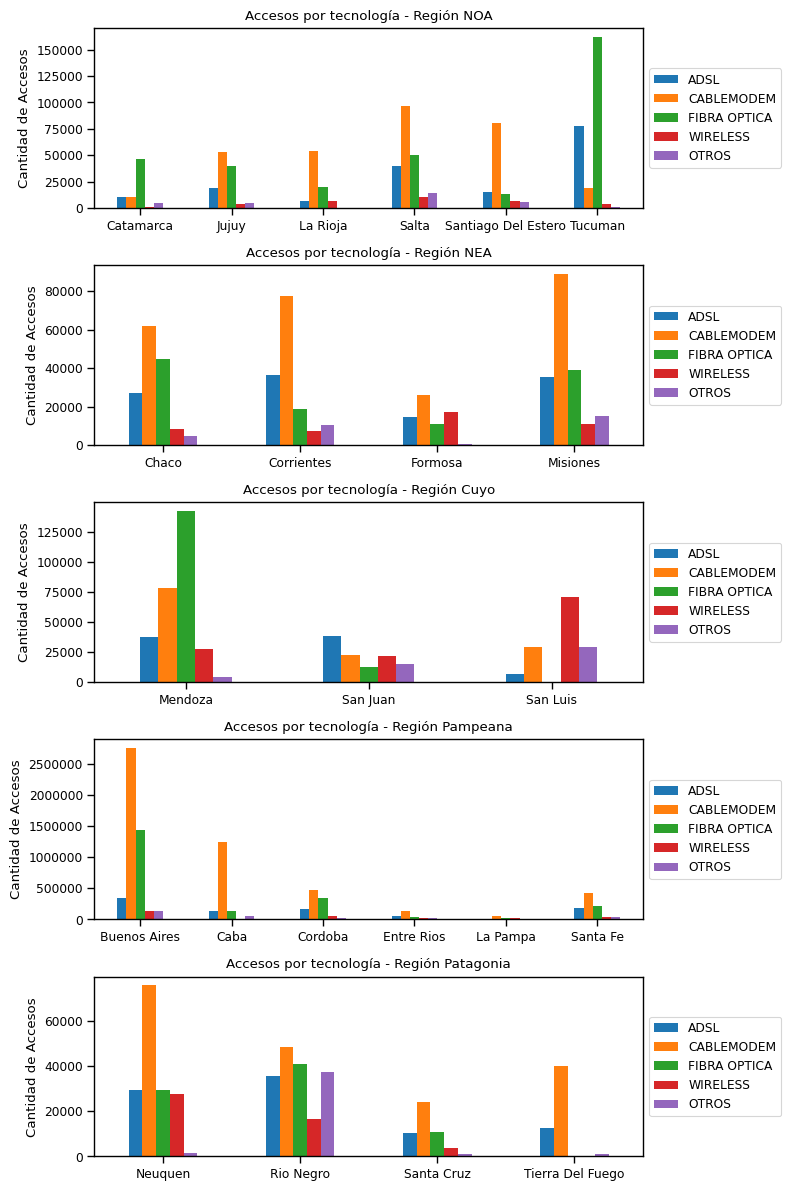

In [170]:
fig, axs = plt.subplots(len(regiones), 1, figsize=(8, 12))
sns.set_context("paper")

for i, (region, provincias) in enumerate(regiones.items()):
    df_region = df_provincias[df_provincias['Provincia'].isin(provincias)]
    ax = axs[i]
    df_region.plot(kind='bar', ax=ax, legend=False)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'Accesos por tecnología - Región {region}')
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_ylabel('Cantidad de Accesos')
    ax.set_xticklabels(df_region['Provincia'], rotation=0)

plt.tight_layout()
plt.show()

De estos gráficos se evidencia que la tecnología dominante en nuestro país es el Cablemodem, seguido por la fibra óptica. Esta idea se refuerza con los dos siguientes gráficos (barras y pie chart) a modo de resumen.

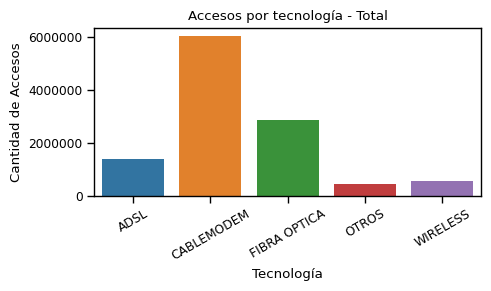

In [171]:
tecnologias = ['ADSL', 'CABLEMODEM', 'FIBRA OPTICA', 'OTROS', 'WIRELESS']
accesos_totales = df_provincias[tecnologias].sum()

sns.set_context("paper")
plt.figure(figsize=(5, 3))
sns.barplot(x=accesos_totales.index, y=accesos_totales.values)
plt.title('Accesos por tecnología - Total')
plt.xlabel('Tecnología')
plt.ylabel('Cantidad de Accesos')
plt.xticks(rotation=30)
plt.ticklabel_format(style='plain', axis='y')  # Desactivar notación científica en eje y
plt.tight_layout()
plt.show()

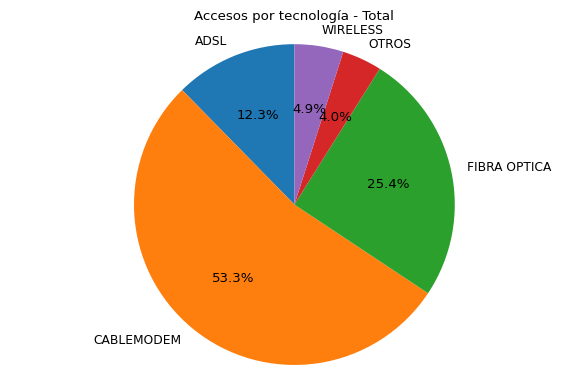

In [172]:
tecnologias = ['ADSL', 'CABLEMODEM', 'FIBRA OPTICA', 'OTROS', 'WIRELESS']
accesos_totales = df_provincias[tecnologias].sum()

plt.figure(figsize=(6, 4))
plt.pie(accesos_totales, labels=accesos_totales.index, autopct='%1.1f%%', startangle=90)
plt.title('Accesos por tecnología - Total')
plt.axis('equal')
plt.tight_layout()
plt.show()
